In [11]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%autoreload 2
import numpy as np
from scipy.stats import unitary_group, ortho_group
from scipy.linalg import khatri_rao
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [13]:
def gauss(x, r, seed):
    np.random.seed(seed)
    return np.random.normal(size = (x, r))

def radem(x, r, seed):
    np.random.seed(seed)
    return 1 - 2 * np.random.randint(low = 0, high = 2, size = (x, r))

def big_gauss(x, r, seed):
    np.random.seed(seed)
    return np.random.normal(size = (x * x, r))

def big_radem(x, r, seed):
    np.random.seed(seed)
    return 1 - 2 * np.random.randint(low = 0, high = 2, size = (x * x, r))

def gauss_gauss(x, r, seed):
    return khatri_rao(gauss(x, r, seed=2 * seed), gauss(x, r, seed=2 * seed + 1))

def gauss_radem(x, r, seed):
    return khatri_rao(gauss(x, r, seed=2 * seed), radem(x, r, seed=2 * seed + 1))

def radem_radem(x, r, seed):
    return khatri_rao(radem(x, r, seed=2 * seed), radem(x, r, seed=2 * seed + 1))

In [15]:
def generate_almost_unit(n, m, noise, seed):
    def inverse_permutation(p):
        p = np.asanyarray(p)
        s = np.empty_like(p)
        s[p] = np.arange(p.size)
        return s

    assert n >= m
    np.random.seed(seed)
    matrix = np.zeros((n, m))
    for i in range(m):
        matrix[i, i] = 1
    noise_matrix = np.random.normal(0, noise, (n, m))
    matrix += noise_matrix
    perm = np.random.permutation(m)
    matrix = matrix[:, perm]
    q, r = np.linalg.qr(matrix, mode='reduced')
    return q[:, inverse_permutation(perm)]

In [17]:
expected = []
variance = []
for base in [1.01, 1.05, 1.18, 1.5, 2, 4.5, 10]:
    n = 100
    u = generate_almost_unit(n, n, 0.1, seed = 0)
    vT = generate_almost_unit(n * n, n, 0.01, seed=0).T
    noise = np.random.normal(0, 1, n)
    sigma = np.logspace(3, 4 - n, base=base, num=n)
    sigma = np.sort(noise * sigma)
    A = u @ np.diag(sigma) @ vT

    for generator, name in zip([big_gauss, big_radem, gauss_gauss, gauss_radem, radem_radem], ['big_gauss', 'big_radem', 'gauss_gauss', 'gauss_radem', 'radem_radem']):
        for r in [7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67]:
            precisions = []
            for seed in range(1, 250):
                Omega = generator(n, r, seed)
                Q, R = np.linalg.qr(A @ Omega)
                B = Q @ (Q.T @ A)
                C = u[:,:r] @ np.diag(sigma[:r]) @ vT[:r, :]
                precisions.append(np.linalg.norm(A - B) ** 2 / np.linalg.norm(A - C) ** 2)
            precisions = np.array(precisions)
            expected.append((r, precisions.mean(), name, base))
            variance.append((r, precisions.var(), name, base))
df_expected = pd.DataFrame(expected, columns=["rank", "precision", "generator_name", "base"])
df_variance = pd.DataFrame(variance, columns=["rank", "precision", "generator_name", "base"])

/tmp/ipykernel_44877/1897898901.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  precisions.append(np.linalg.norm(A - B) ** 2 / np.linalg.norm(A - C) ** 2)
/home/divanik/.local/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Base =  1.01


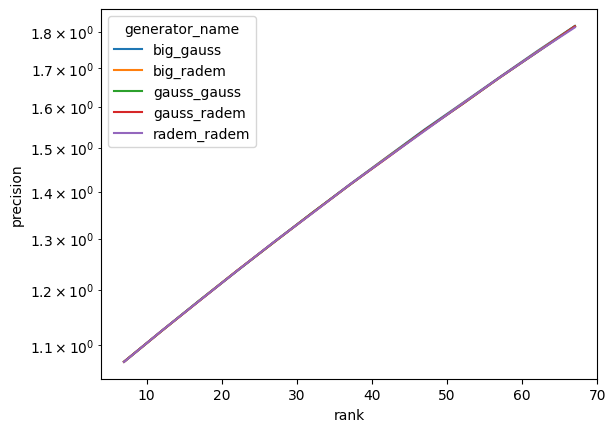

Base =  1.05


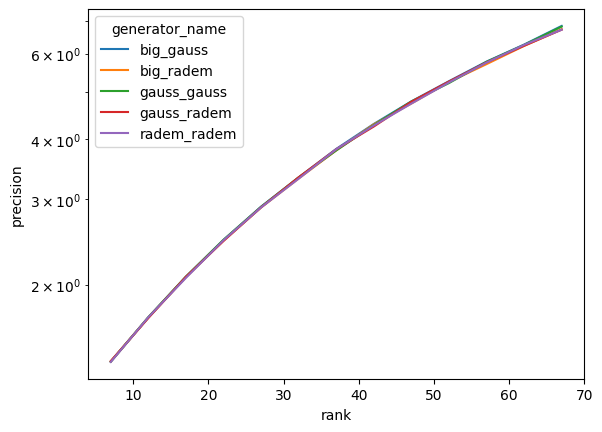

Base =  1.18


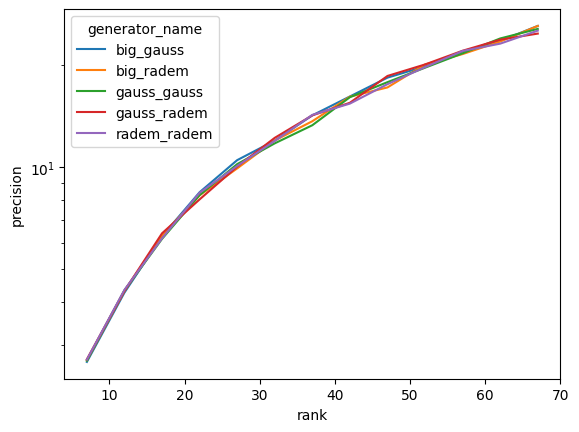

Base =  1.5


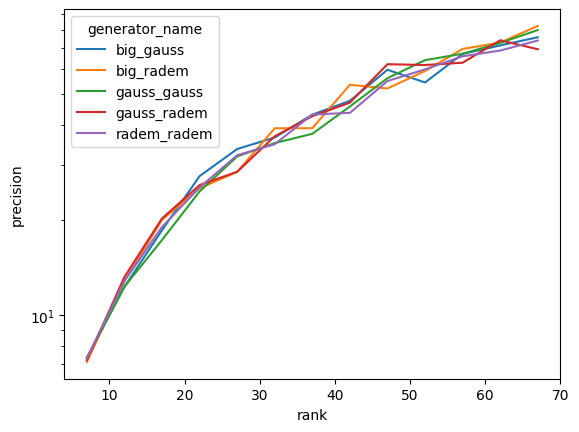

Base =  2


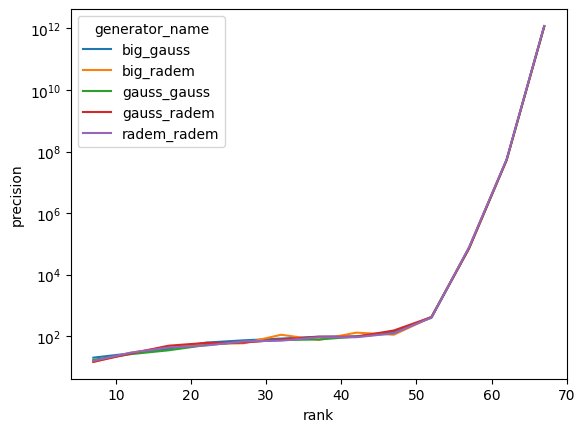

Base =  4.5


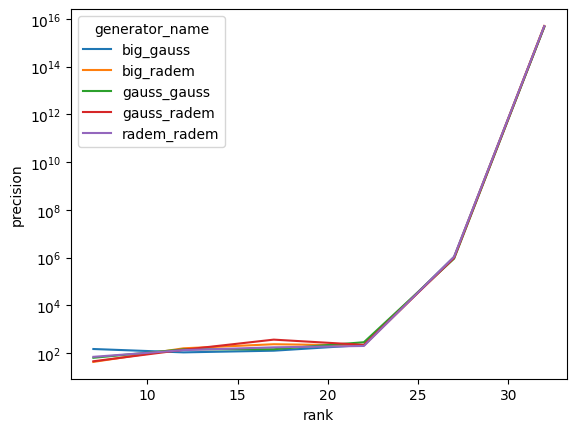

Base =  10


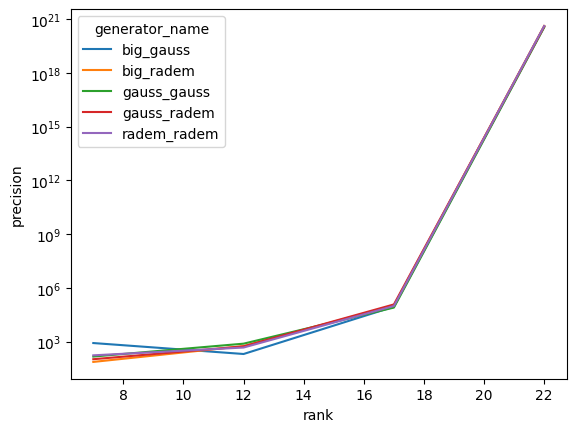

In [22]:
for base in [1.01, 1.05, 1.18, 1.5, 2, 4.5, 10]:
    print("Base = ", base)
    fig, ax = plt.subplots(1, 1)
    sns.lineplot(data=df_expected[df_expected["base"] == base], x='rank', y='precision', hue='generator_name', ax=ax)
    ax.set_yscale('log')
    plt.show()

Base =  1.01


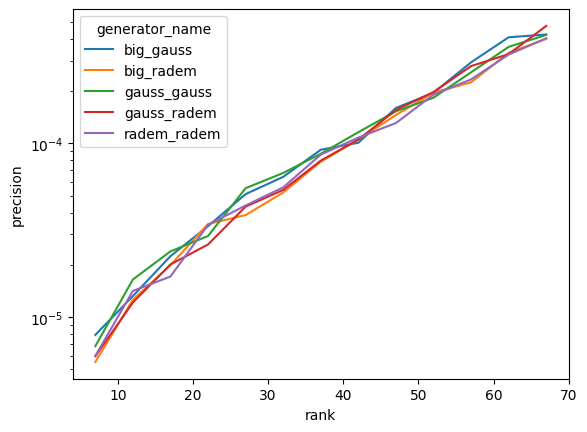

Base =  1.05


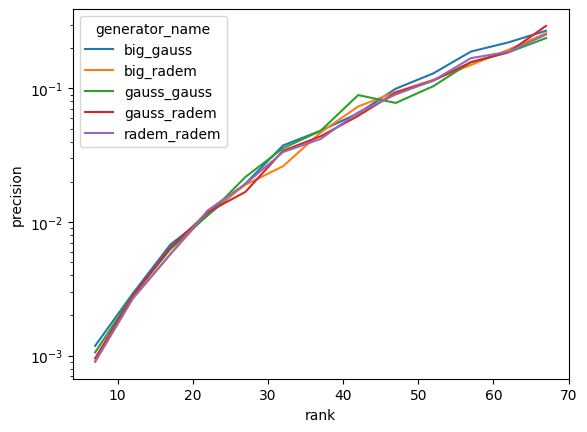

Base =  1.18


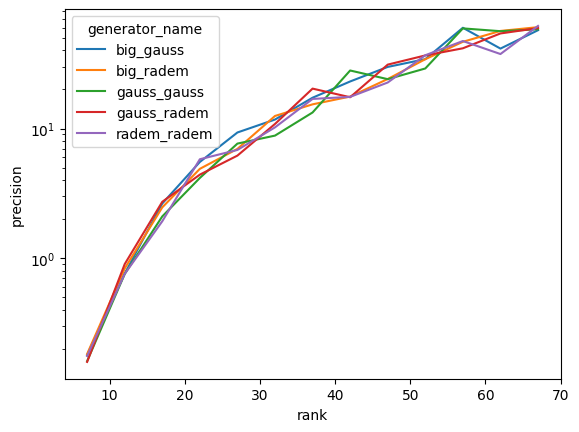

Base =  1.5


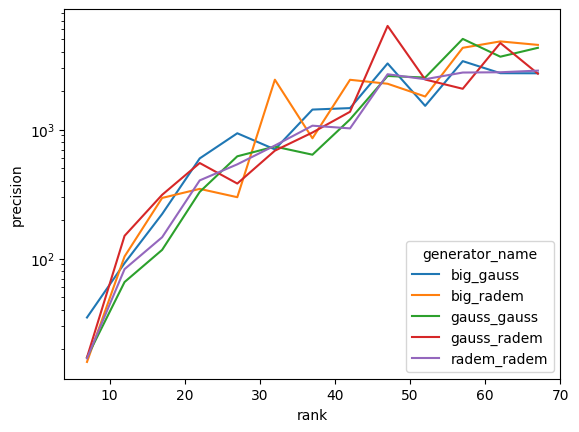

Base =  2


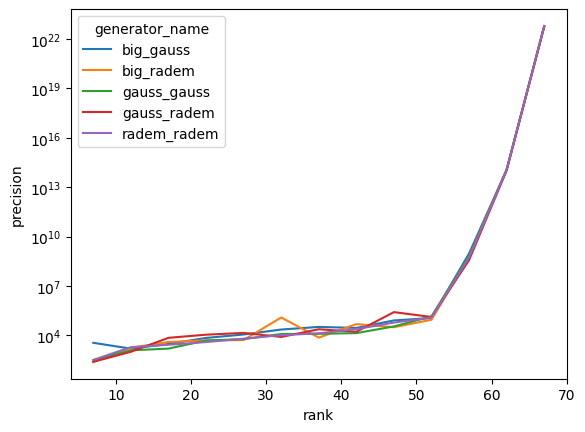

Base =  4.5


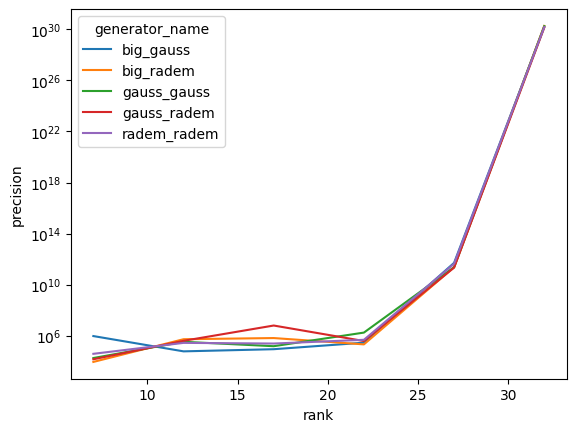

Base =  10


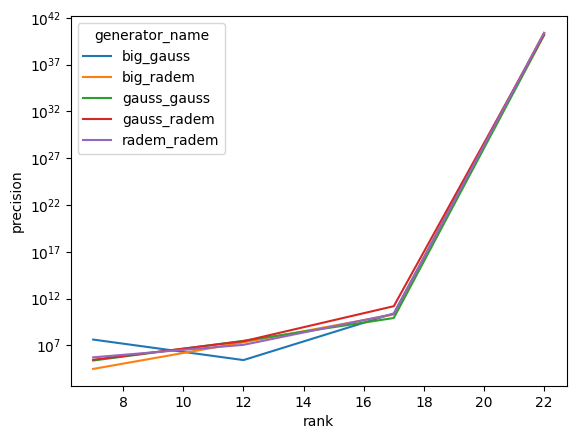

In [19]:
for base in [1.01, 1.05, 1.18, 1.5, 2, 4.5, 10]:
    print("Base = ", base)
    fig, ax = plt.subplots(1, 1)
    sns.lineplot(data=df_variance[df_variance["base"] == base], x='rank', y='precision', hue='generator_name', ax=ax)
    ax.set_yscale('log')
    plt.show()

In [20]:
df_expected.to_csv('../experiments_results/experiment3/expected.csv')
df_variance.to_csv('../experiments_results/experiment3/variance.csv')